In [67]:
# referenced code here: https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/
# also found this interesting https://medium.com/@phindulo60/portfolio-optimization-with-python-mean-variance-optimization-mvo-and-markowitzs-efficient-64acb3b61ef6
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

aapl = pd.read_csv("Dataset\Equities\AAPL.csv")
meta = pd.read_csv("Dataset\Equities\META.csv")
orcl = pd.read_csv("Dataset\Equities\ORCL.csv")

df_aapl = pd.DataFrame(data=aapl)
df_meta = pd.DataFrame(data=meta)
df_orcl = pd.DataFrame(data=orcl)
df_aapl.rename(columns={"Close": "aapl_close"}, inplace=True)
df_meta.rename(columns={"Close": "meta_close"}, inplace=True)
df_orcl.rename(columns={"Close": "orcl_close"}, inplace=True)
# print(df_aapl)

aapl_close = df_aapl["aapl_close"]
meta_close = df_meta["meta_close"]
orcl_close = df_orcl["orcl_close"]


# print(aapl_close)
# print(meta_close)
# print(orcl_close)
assert aapl_close.shape == meta_close.shape == orcl_close.shape

date = pd.to_datetime(df_aapl["Date"])
portfolio = pd.DataFrame(date)
portfolio = portfolio.join(aapl_close)
portfolio = portfolio.join(meta_close)
portfolio = portfolio.join(orcl_close)
# print(portfolio)
# print(f"portfolio shape: {portfolio.shape}")

portfolio.set_index('Date', inplace=True)

In [68]:
portfolio

,aapl_close,meta_close,orcl_close
Date,,,
2014-05-27,22.343929,63.480000,41.910000
2014-05-28,22.286072,63.509998,41.570000
2014-05-29,22.692142,63.830002,42.200001
2014-05-30,22.607143,63.299999,42.020000
2014-06-02,22.451786,63.080002,41.970001
...,...,...,...
2024-05-20,191.039993,468.839996,124.519997
2024-05-21,192.350006,464.630005,124.629997
2024-05-22,190.899994,467.779999,124.599998


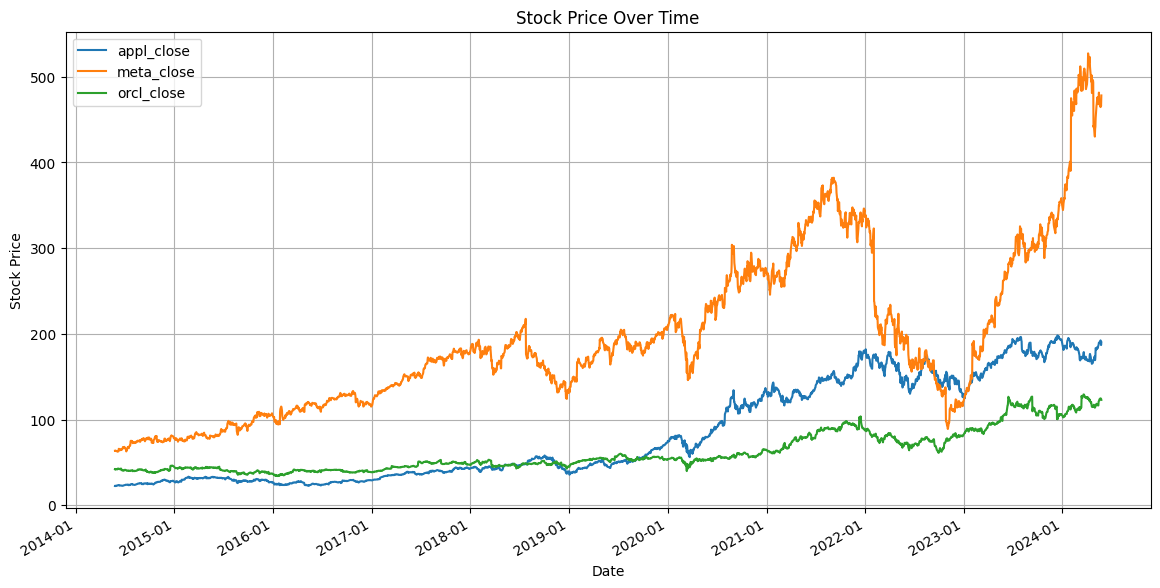

In [69]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(portfolio["aapl_close"], label="appl_close")
ax.plot(portfolio["meta_close"], label="meta_close")
ax.plot(portfolio["orcl_close"], label="orcl_close")

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Stock Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.grid(True)

plt.show()

In [70]:
from scipy.optimize import minimize
import numpy as np

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

#! Let's set a target return of 9.0 (900%)
target_return = 1.5

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Number of portfolios to simulate
num_portfolios = 10000
num_stocks = len(portfolio.columns)

# Initialize arrays to store portfolio weights, returns and volatility
weights_array = np.zeros((num_portfolios, num_stocks))
returns_array = np.zeros(num_portfolios)
volatility_array = np.zeros(num_portfolios)

# Simulate random portfolios
#! 252 is used to annualize the data (252 trading days in the US)
for i in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    weights_array[i,:] = weights
    returns_array[i] = np.sum(mean_returns * weights) * 252
    volatility_array[i] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Define the objective function (portfolio variance)
#! 252 is used to annualize the data (252 trading days in the US)
def objective(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Define the constraint (portfolio return should be equal to the target return)
#! 252 is used to annualize the data (252 trading days in the US)
def constraint1(weights):
    return np.sum(mean_returns * weights) * 252 - target_return

# Define the constraint (the sum of the weights should be equal to 1)
def constraint2(weights):
    return np.sum(weights) - 1

# Define the bounds and constraints for the optimization
bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2})

# Perform the optimization
result = minimize(objective, num_stocks*[1./num_stocks,], bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights = result.x

In [71]:
returns

,aapl_close,meta_close,orcl_close
Date,,,
2014-05-27,NaN,NaN,NaN
2014-05-28,-0.002589,0.000473,-0.008113
2014-05-29,0.018221,0.005039,0.015155
2014-05-30,-0.003746,-0.008303,-0.004265
2014-06-02,-0.006872,-0.003475,-0.001190
...,...,...,...
2024-05-20,0.006162,-0.006505,0.008259
2024-05-21,0.006857,-0.008980,0.000883
2024-05-22,-0.007538,0.006780,-0.000241


optimal_weights: [3.95025175e-12 1.00000000e+00 9.53042510e-17]
initial portfolio values: aapl_close    22.343929
meta_close    63.480000
orcl_close    41.910000
Name: 2014-05-27 00:00:00, dtype: float64
final portfolio values: aapl_close    189.979996
meta_close    478.220001
orcl_close    122.910004
Name: 2024-05-24 00:00:00, dtype: float64
(After Optim) initial portfolio values: 63.48
(After Optim) final portfolio values: 478.220001


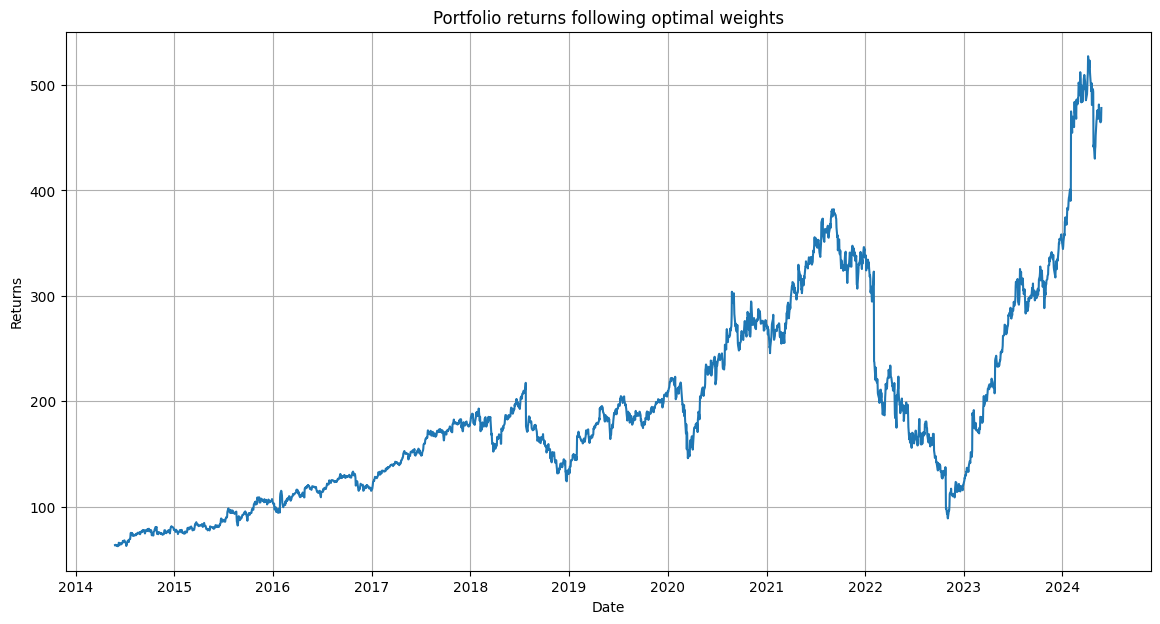

In [72]:
# print(f"num stocks: {num_stocks}")
# 
# print(f"result type: {type(result)}")
# print(f"result: {result}")
print(f"optimal_weights: {optimal_weights}")
print(f"initial portfolio values: {portfolio.iloc[0, :]}")
print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights)
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()